# Baseball
+ This is a Bayesian practice in analyzing Baseball statistics. Many thanks to the great blog @[Variance Explained](http://varianceexplained.org/).

------------
### Objective
Faily evaluating the performance of a player could be hard sometimes when there is little information available. It might be suspicious to say a player, who keeps a record of batting average 8/10, is better than another one, who gets an average 200/500. Now, let Bayesian Statistics make help. This practice was conducted under the guidance from blog @[Variance Explained](http://varianceexplained.org/). It covers empirical Bayesian prior estimates, hierarchical modeling, mixture model, hypothese testing and simulation.

### Data Description
To access to the data, click the [link](https://github.com/chadwickbureau/baseballdatabank)!

Variable|Definition|Note
---|---|---
playerID|A unique code asssigned to each player|The playerID links the data in this file with records in the other files
nameFirst|Player's first name|
nameLast|Player's last name|
bats|Player's batting hand|L = left handed, R = Right handed, B = Both
lgID|League|
AB|At Bats| 
H|Hits|
2B|Doubles|
3B|Triples|
HR|Homeruns|
G|Games played|

-----------------
### Under Construction
Credible Interval, Hypothesis testing, FDR control, Simulation, Document Formatting

-----------------

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import math
pd.options.mode.chained_assignment = None

In [2]:
batting = pd.read_csv('batting.csv')
master = pd.read_csv('master.csv')
pitching = pd.read_csv('pitching.csv')

In [3]:
pitching = pitching.groupby('playerID',as_index = False).sum()
pitching = pitching[pitching.G > 3]
batting = batting[(batting.lgID == 'NL') & (batting.yearID > 1980)]
batting = batting.groupby(['playerID'],as_index = False).sum()
batting = batting[(batting.AB > 20)]
batting['isPitcher'] = batting.playerID.isin(pitching.playerID)
master[['nameFirst','nameLast']] = master[['nameFirst','nameLast']].fillna('NaN')
master['name'] = master[['nameFirst','nameLast']].apply(lambda x: ' '.join(x), axis = 1)

In [4]:
df = pd.merge(batting, master, how = 'left', on = 'playerID')
df = df[~pd.isnull(df.bats)]

In [5]:
career = df[['name','H','AB','isPitcher','bats']]
career['Average_rate'] = df.H.astype(float) / df.AB
career = pd.get_dummies(career, columns = ['bats'])

In [6]:
career.head(10)

,name,H,AB,isPitcher,Average_rate,bats_B,bats_L,bats_R
0,Jeff Abbott,11,42,False,0.261905,0,0,1
1,Jim Abbott,2,21,True,0.095238,0,1,0
2,Kurt Abbott,475,1860,False,0.255376,0,0,1
3,Kyle Abbott,3,31,True,0.096774,0,1,0
4,Reggie Abercrombie,86,386,False,0.222798,0,0,1
5,Shawn Abner,110,531,False,0.207156,0,0,1
6,Bobby Abreu,1607,5395,False,0.297868,0,1,0
7,Tony Abreu,129,509,False,0.253438,1,0,0
8,Jose Acevedo,8,101,True,0.079208,0,0,1
9,Juan Acevedo,6,65,True,0.092308,0,0,1


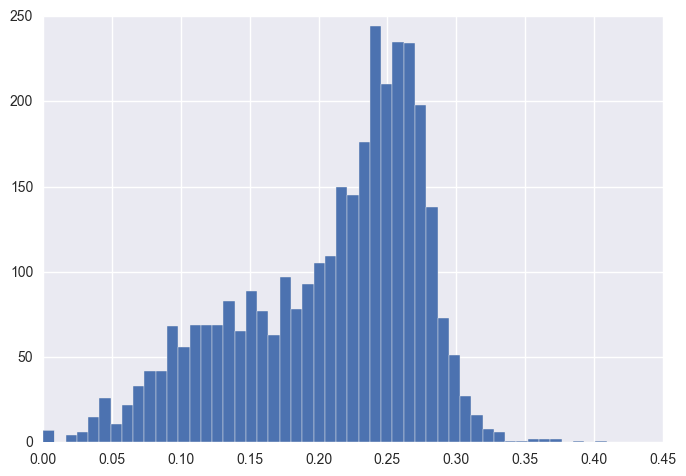

In [7]:
plt.figure()
plt.hist(x = career.Average_rate, bins = 50)
plt.show()

I. Average Rate Adjustment

A. Prior with Beta Distribution (Method of Moment)

In [8]:
import scipy as sp
mu = np.average(career.Average_rate)
variance = np.average(career.Average_rate**2) - np.average(career.Average_rate) ** 2
a_b = mu * (1 - mu) / variance - 1

In [9]:
alpha0 = mu * a_b
beta0 = a_b - alpha0

In [10]:
alpha0

7.5353701781416769

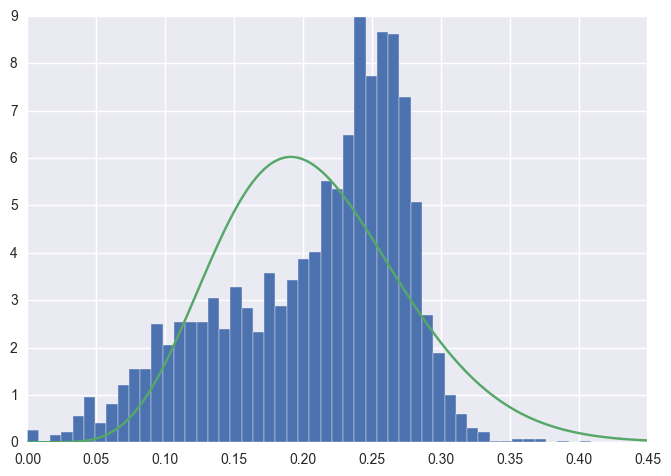

In [11]:
plt.figure()
plt.hist(x = career.Average_rate, bins = 50, normed = True)
x = np.linspace(0,0.45,500)
pdf = sp.stats.beta.pdf(x, alpha0, beta0) 
plt.plot(x, pdf, '-')
plt.show()

In [12]:
#Posterior
alpha0_post, beta0_post = alpha0 + career.H, beta0 - career.H + career.AB
ar0_post = alpha0_post / (alpha0_post + beta0_post)
ci = np.stack([sp.stats.beta.ppf(0.025, alpha0_post, beta0_post), sp.stats.beta.ppf(0.975, alpha0_post, beta0_post)],axis=1)

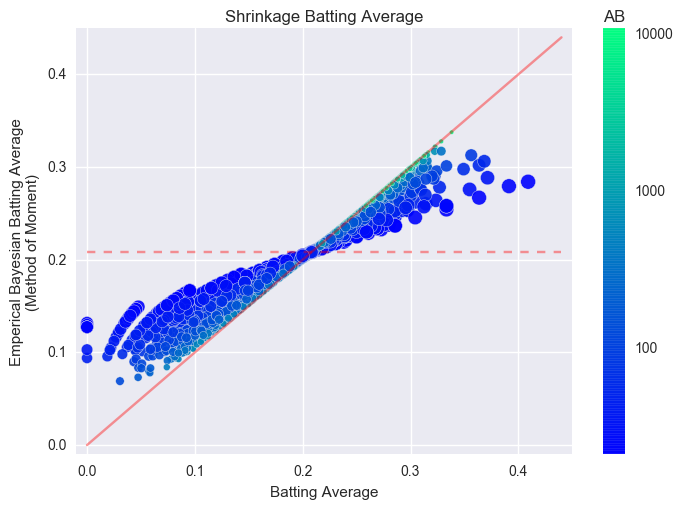

In [13]:
fig = plt.figure()
x = np.arange(0.0,0.45,0.01)

ax1 = plt.subplot(111) 
sc1 = ax1.scatter(career.Average_rate, ar0_post, cmap = plt.cm.winter, c = np.log10(career.AB), s = 500*np.array([u-l for l,u in ci]),alpha=0.9)
cb1 = plt.colorbar(sc1, ticks = [2,3,4])
cb1.ax.set_yticklabels([100,1000,10000])
cb1.ax.set_title('AB')
ax1.plot(x,x,'r',alpha=0.4)
ax1.plot(x,np.array([alpha0 / (alpha0 + beta0)] * len(x)),'r--',alpha=0.4)
ax1.set_xlabel('Batting Average')
ax1.set_ylabel('Emperical Bayesian Batting Average\n(Method of Moment)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.title('Shrinkage Batting Average')

plt.show()

B. Prior with Mixture Effect Beta-Binomial Model

B1. No factors

In [14]:
from scipy.optimize import minimize
from scipy.special import gammaln

def bb(s, n, a, b):
    return gammaln(n+1) + gammaln(s+a) + gammaln(n-s+b) + gammaln(a+b) - (gammaln(s+1) + gammaln(n-s+1) + gammaln(a) + gammaln(b) + gammaln(a + b + n))

def ll_bb(para, data):
    alpha = para[0]
    beta = para[1]
    ll = - np.sum(bb(data.H, data.AB, alpha, beta))
    return ll

def fit_mle_bb(data):
    res = minimize(ll_bb, x0 = np.array([18,70]), args = data, method = 'BFGS')
    alpha, beta = res.x
    return alpha, beta
    
def mix_bb(data, n, k):
    
    np.random.seed(2017)
    z = np.array([np.random.permutation([0] * (k-1) + [1]) for i in range(len(data))])
    p = z.sum(axis = 0) / float(len(data))
    lp = np.array([0.0] * len(data) * k).reshape(len(data),k)

    para = {'alpha': np.ndarray((n,k)),
            'beta':np.ndarray((n,k)),
            'prior':np.ndarray((n,k))}
    
    for i in range(n):
        for j in range(k):
            a, b = fit_mle_bb(data[z[:,j] == 1])
            lp[:,j] = np.exp(bb(data.H, data.AB, a, b))
            para['alpha'][i,j] = a
            para['beta'][i,j] = b
        z = np.apply_along_axis(lambda x: x == np.max(x), 1 , lp)
        p = z.sum(axis = 0) / float(len(data))
        para['prior'][i,:] = p

    return para

In [15]:
para_0 = mix_bb(career, 10, 2)

In [16]:
para_0

{'alpha': array([[  13.88100508,   11.55288758],
        [ 134.98092232,    5.54367412],
        [ 127.21894889,   16.91120092],
        [ 136.88796089,   24.3908726 ],
        [ 135.35870254,   25.42774865],
        [ 137.11109492,   25.82413516],
        [ 137.11109492,   25.82413516],
        [ 137.11109492,   25.82413516],
        [ 137.11109492,   25.82413516],
        [ 137.11109492,   25.82413516]]),
 'beta': array([[  49.0958489 ,   41.41573842],
        [ 403.26218575,   34.30157645],
        [ 368.30121303,  106.74582714],
        [ 394.92570374,  153.18131201],
        [ 390.81767126,  160.42543299],
        [ 395.85450987,  162.89236598],
        [ 395.85450987,  162.89236598],
        [ 395.85450987,  162.89236598],
        [ 395.85450987,  162.89236598],
        [ 395.85450987,  162.89236598]]),
 'prior': array([[ 0.707442  ,  0.292558  ],
        [ 0.66134378,  0.33865622],
        [ 0.65109973,  0.34890027],
        [ 0.65230491,  0.34769509],
        [ 0.6529075 ,  0.3

In [17]:
alpha_0, beta_0, prior_0 = para_0['alpha'][-1], para_0['beta'][-1], para_0['prior'][-1]

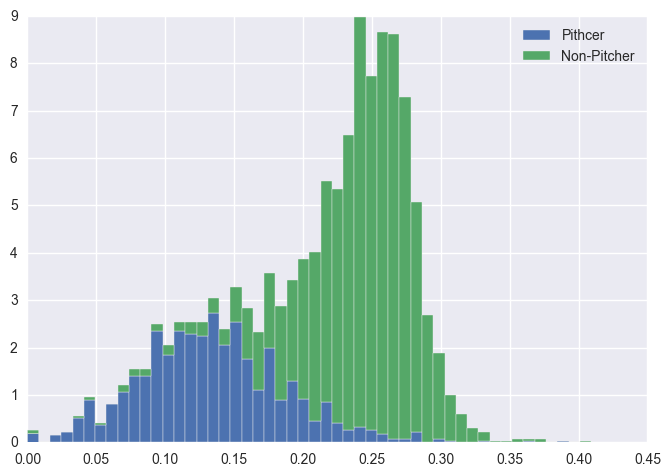

In [18]:
plt.figure()
plt.hist(x = [career.Average_rate[career.isPitcher == True], career.Average_rate[career.isPitcher == False]], bins = 50, stacked=True, label = ['Pithcer','Non-Pitcher'], rwidth = 1, normed = True,)
plt.legend(loc='best')
plt.show()

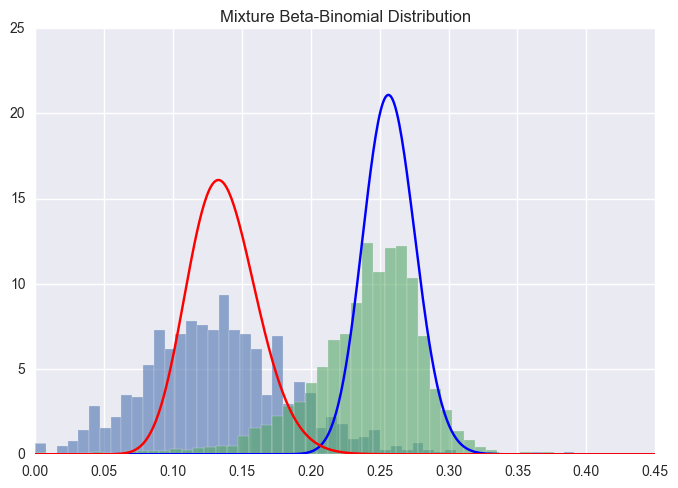

In [21]:
plt.figure()
plt.title('Mixture Beta-Binomial Distribution')
plt.hist(x = career.Average_rate[career.isPitcher == True], bins = 50, normed = True, alpha = 0.6, label = 'Pitcher')
plt.hist(x = career.Average_rate[career.isPitcher == False], bins = 50, normed = True, alpha = 0.6, label = 'Non-Pitcher')
x = np.linspace(0,0.45,500)
pdf1 = sp.stats.beta.pdf(x, alpha_0[0], beta_0[0])
pdf2 = sp.stats.beta.pdf(x, alpha_0[1], beta_0[1])
plt.plot(x, pdf1, 'b-')
plt.plot(x, pdf2, 'r-')
plt.show()

In [22]:
#Assign using beta-binomial distribution
post1_0 = - bb(career.H, career.AB, alpha_0[0], beta_0[0]) * prior_0[0]
post2_0 = - bb(career.H, career.AB, alpha_0[1], beta_0[1]) * prior_0[1]
post1_0 = post1_0 / (post1_0 + post2_0)
post2_0 = 1 - post1_0
isPitcher_guess0 = post2_0 < post1_0

In [23]:
#Posterior Expectation
alpha_0_post, beta_0_post = np.array([alpha_0 + s for s in career.H]) , np.array([beta_0 + n - s for s, n in zip(career.H, career.AB)])
ar_0_post = np.sum(np.array([x / (x + y) for x, y in zip(alpha_0_post, beta_0_post)])* np.stack([post1_0,post2_0],axis=1), axis = 1) 

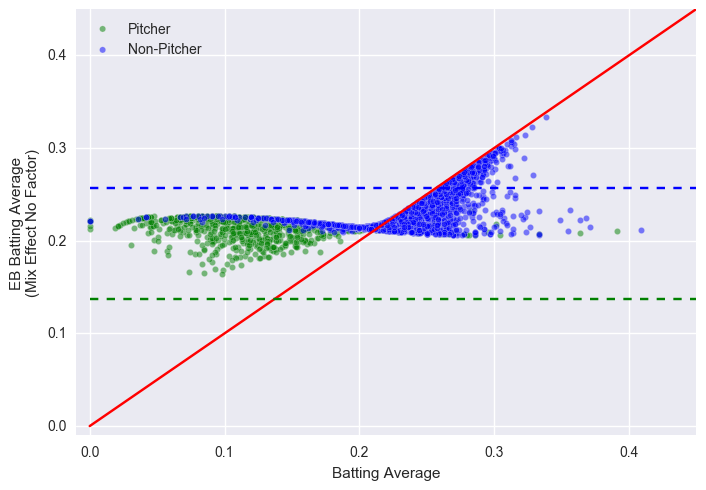

In [24]:
fig = plt.figure()
x = np.arange(0.0,0.5,0.01)

ax2 = plt.subplot(111) 
ax2.scatter(career.Average_rate[career.isPitcher], ar_0_post[np.array(career.isPitcher)], c = 'g', alpha=0.5, label='Pitcher')
ax2.scatter(career.Average_rate[~career.isPitcher], ar_0_post[np.array(~career.isPitcher)], c = 'b', alpha=0.5, label='Non-Pitcher')
ax2.plot(x,x,'r')
ax2.plot(x,([alpha_0[0] / (alpha_0[0] + beta_0[0])] * len(x)),'b--')
ax2.plot(x,([alpha_0[1] / (alpha_0[1] + beta_0[1])] * len(x)),'g--')
ax2.set_xlabel('Batting Average')
ax2.set_ylabel('EB Batting Average\n(Mix Effect No Factor)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.legend(loc = 'best')

plt.show()

B2. Factor AB

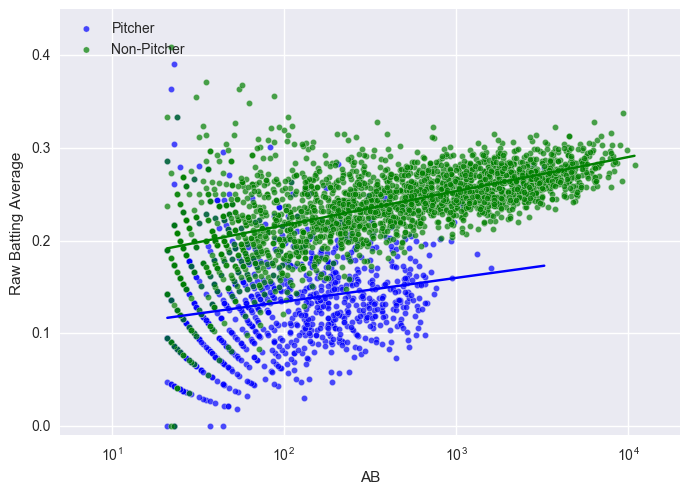

In [25]:
fig = plt.figure()
ax3_0 = plt.subplot(111)
ax3_0.scatter(career.AB[career.isPitcher], career.Average_rate[np.array(career.isPitcher)], c = 'b', label = 'Pitcher', alpha = 0.7)
ax3_0.scatter(career.AB[~career.isPitcher], career.Average_rate[np.array(~career.isPitcher)], c = 'g', label = 'Non-Pitcher', alpha = 0.7)
ax3_0.plot(np.unique((career.AB[career.isPitcher])),np.poly1d(np.polyfit(np.log(career.AB[career.isPitcher]), career.Average_rate[career.isPitcher], 1))(np.unique(np.log(career.AB[career.isPitcher]))),'b')
ax3_0.plot(np.unique((career.AB[~career.isPitcher])),np.poly1d(np.polyfit(np.log(career.AB[~career.isPitcher]), career.Average_rate[~career.isPitcher], 1))(np.unique(np.log(career.AB[~career.isPitcher]))),'g')
ax3_0.set_xlabel('AB')
ax3_0.set_ylabel('Raw Batting Average')
ax3_0.set_xscale('log')
plt.xlim([5,20000])
plt.ylim([-0.01,0.45])
plt.legend(loc=2)
plt.show()

In [26]:
import statsmodels.api as sm
import bbreg
transform_log = sm.families.links.Log()
transform_logit = sm.families.links.Logit()

In [27]:
def mix_beta_factor(h, ab, exog, n, k, label_factor = None):
    
    num_obs = len(h)
    exog = sm.add_constant(exog, prepend = True)
    num_factor = exog.shape[1]
    if label_factor != None:
        assert((num_factor - 1) == len(label_factor))
        label_factor = ['Intercept'] + label_factor
    
    para = {'prior':np.ndarray((n,k)),
                        'phi': np.ndarray((n,k))}
    for m in range(num_factor):
        if label_factor == None:
            para['coef_%s' % m] = np.ndarray((n,k))
        else:
            para[label_factor[m]] = np.ndarray((n,k))

    np.random.seed(2017)
    z = np.array([np.random.permutation([0] * (k-1) + [1]) for i in range(num_obs)])
    p = z.sum(axis = 0) / float(num_obs)
    lp = np.array([0.0] * num_obs * k).reshape(num_obs,k)
    
    for i in range(n):
        for j in range(k):
            model = bbreg.BB(endog = np.stack([h, ab - h],axis = 1)[z[:,j] == 1], exog = exog[z[:,j] == 1])
            params = model.fit().params
            lp[:,j] = - model._ll_br(np.stack([h, ab - h],axis = 1), exog, np.ones((num_obs, 1), dtype='f'), params)
            
            for m in range(num_factor):
                if label_factor == None:
                    para['coef_%s' %(m)][i,j] = params[m]
                else:
                    para[label_factor[m]][i,j] = params[m]
            para['phi'][i,j] = params[-1]
       
        z = np.apply_along_axis(lambda x: x == np.max(x), 1 , lp)
        p = z.sum(axis = 0) / float(num_obs)
        para['prior'][i,:] = p

    return para

In [28]:
para1 = mix_beta_factor(career.H, career.AB, np.log(career.AB),15,2)

In [29]:
para1

{'coef_0': array([[-2.21952454, -2.26795762],
        [-3.07274492, -1.74504873],
        [-1.57621046, -3.41568668],
        [-3.52584167, -1.44457864],
        [-1.34953379, -3.59822153],
        [-3.61323557, -1.29499047],
        [-1.27759732, -3.59632914],
        [-3.56122192, -1.26457475],
        [-1.26102595, -3.54410037],
        [-3.52448147, -1.26570179],
        [-1.26902886, -3.51023784],
        [-3.49544834, -1.27967009],
        [-1.28702466, -3.49280537],
        [-3.49341541, -1.2933592 ],
        [-1.30147223, -3.4932978 ]]),
 'coef_1': array([[ 0.21284273,  0.22015221],
        [ 0.33265955,  0.15018908],
        [ 0.12843877,  0.37357835],
        [ 0.38350041,  0.11150407],
        [ 0.09948321,  0.38914669],
        [ 0.38824705,  0.09297502],
        [ 0.0914446 ,  0.38483302],
        [ 0.37872381,  0.09016127],
        [ 0.08997792,  0.37594742],
        [ 0.37248315,  0.09089563],
        [ 0.09163444,  0.3699792 ],
        [ 0.36661899,  0.09366591],
      

In [30]:
coef0_1, coef1_1, phi_1, prior_1 = para1['coef_0'][-1], para1['coef_1'][-1], para1['phi'][-1], para1['prior'][-1]

In [31]:
model = bbreg.BB(np.stack([career.H, career.AB - career.H],axis = 1), np.log(career.AB))
post1_1 = - model._ll_br(np.stack([career.H, career.AB - career.H],axis = 1), sm.add_constant(np.log(career.AB), prepend = True), np.ones((len(career), 1), dtype='f'), [coef0_1[0],coef1_1[0],phi_1[0]]) * prior_1[0]
post2_1 = - model._ll_br(np.stack([career.H, career.AB - career.H],axis = 1), sm.add_constant(np.log(career.AB), prepend = True), np.ones((len(career), 1), dtype='f'), [coef0_1[1],coef1_1[1],phi_1[1]]) * prior_1[1]
post1_1 = post1_1 / (post1_1 + post2_1)
post2_1 = 1 - post1_1
isPitcher_guess1 = post1_1 > post2_1

In [32]:
#Posterior
mu1 = transform_logit.inverse(np.array([coef0_1 + coef1_1 * x for x in np.log(career.AB)]))
phi1 = transform_log.inverse(phi_1)
alpha_1_post, beta_1_post = np.array([x * phi1 + s for x, s in zip(mu1,career.H)]), np.array([phi1 - x * phi1 + n - s for x, s, n in zip(mu1, career.H, career.AB)])
ar_1_post = np.sum(np.array([x / (x + y) for x, y in zip(alpha_1_post, beta_1_post)])* np.stack([post1_1,post2_1],axis=1), axis = 1) 

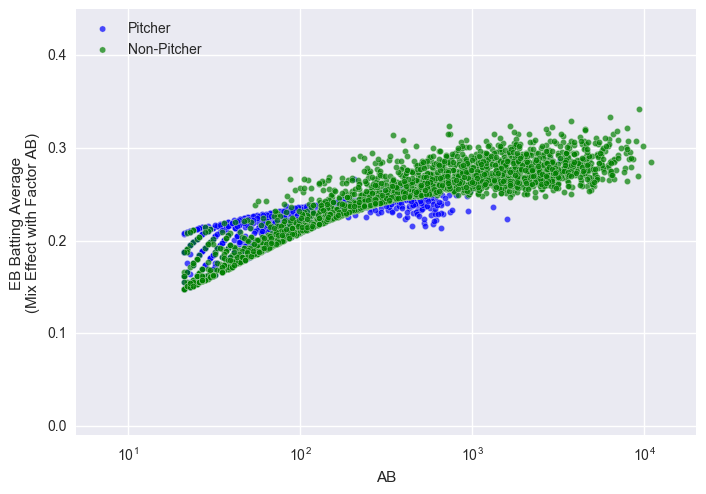

In [33]:
fig = plt.figure()

ax3_1 = plt.subplot(111) 
ax3_1.scatter(career.AB[career.isPitcher], ar_1_post[np.array(career.isPitcher)], c = 'b', label = 'Pitcher', alpha = 0.7)
ax3_1.scatter(career.AB[~career.isPitcher], ar_1_post[np.array(~career.isPitcher)], c = 'g', label = 'Non-Pitcher', alpha = 0.7)
ax3_1.set_xlabel('AB')
ax3_1.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
ax3_1.set_xscale('log')
plt.xlim([5,20000])
plt.ylim([-0.01,0.45])
plt.legend(loc=2)

plt.show()

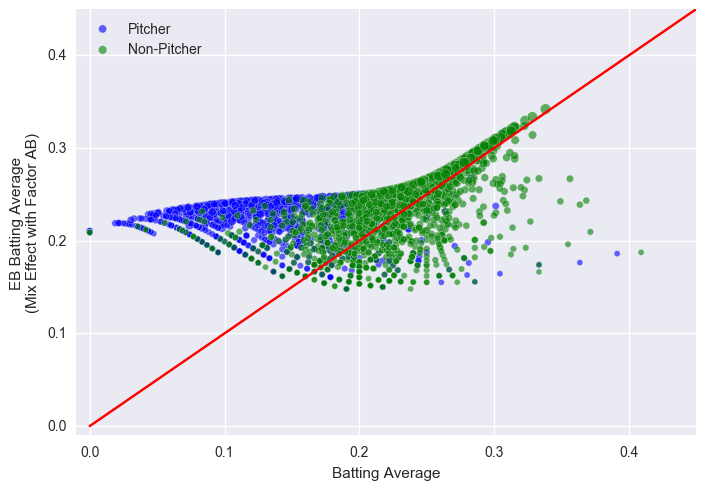

In [34]:
fig = plt.figure()
x = np.arange(0.0,0.5,0.01)

ax3_2 = plt.subplot(111) 
ax3_2.scatter(career.Average_rate[career.isPitcher], ar_1_post[np.array(career.isPitcher)], s = 6 * np.log(career.AB[career.isPitcher]), c = 'b', label = 'Pitcher', alpha = 0.6)
ax3_2.scatter(career.Average_rate[~career.isPitcher], ar_1_post[np.array(~career.isPitcher)], s = 6 * np.log(career.AB[~career.isPitcher]), c = 'g', label = 'Non-Pitcher', alpha = 0.6)
ax3_2.plot(x,x,'r')
ax3_2.set_xlabel('Batting Average')
ax3_2.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.legend(loc='best')

plt.show()

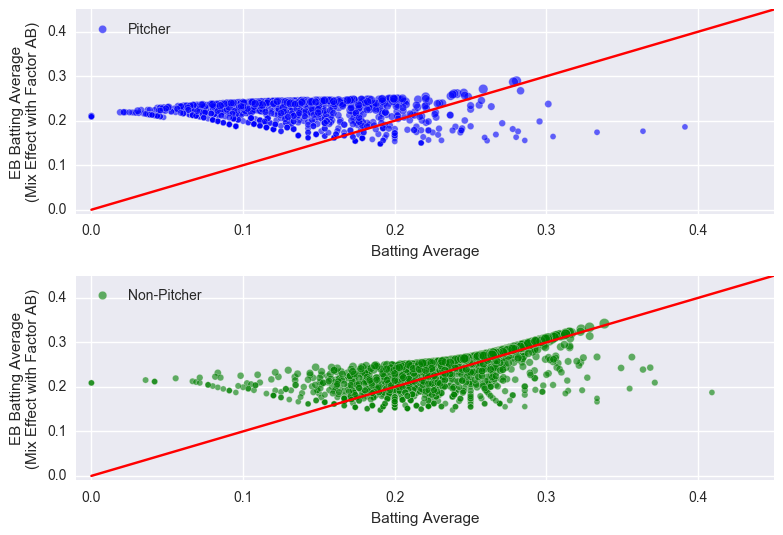

In [35]:
fig = plt.figure()
x = np.arange(0.0,0.5,0.01)

ax3_3 = plt.subplot(211) 
ax3_3.scatter(career.Average_rate[career.isPitcher], ar_1_post[np.array(career.isPitcher)], s = 6 * np.log(career.AB[career.isPitcher]), c = 'b', label = 'Pitcher', alpha = 0.6)
ax3_3.plot(x,x,'r')
ax3_3.set_xlabel('Batting Average')
ax3_3.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.legend(loc='best')

ax3_4 = plt.subplot(212) 
ax3_4.scatter(career.Average_rate[~career.isPitcher], ar_1_post[np.array(~career.isPitcher)], s = 6 * np.log(career.AB[~career.isPitcher]), c = 'g', label = 'Non-Pitcher', alpha = 0.6)
ax3_4.plot(x,x,'r')
ax3_4.set_xlabel('Batting Average')
ax3_4.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])
plt.legend(loc='best')

plt.tight_layout(h_pad=1.1)
plt.show()

B3. Factor: AB + Batting hand

In [36]:
para2 = mix_beta_factor(career.H, career.AB, pd.concat([np.log(career.AB),career.bats_R,career.bats_B], axis=1),10,2)

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [37]:
para2

{'coef_0': array([[-2.14885171, -2.19394321],
        [-2.97718371, -1.68789012],
        [-1.53985872, -3.29131955],
        [-3.4305191 , -1.41145865],
        [-1.32384072, -3.51203394],
        [-3.50946135, -1.26757249],
        [-1.24589163, -3.47172622],
        [-3.4493124 , -1.24025982],
        [-1.2356925 , -3.42123507],
        [-3.38752626, -1.24350297]]),
 'coef_1': array([[ 0.20921762,  0.21641339],
        [ 0.32537447,  0.14664879],
        [ 0.12675548,  0.36104663],
        [ 0.37705838,  0.11046131],
        [ 0.0996307 ,  0.38518098],
        [ 0.38140341,  0.09287441],
        [ 0.09052728,  0.37563548],
        [ 0.37225176,  0.09031966],
        [ 0.09048009,  0.36704082],
        [ 0.36050101,  0.09215902]]),
 'coef_2': array([[-0.08971568, -0.09738137],
        [-0.14696156, -0.04925057],
        [-0.03753443, -0.11292401],
        [-0.1111495 , -0.03631254],
        [-0.03725097, -0.11432397],
        [-0.10952413, -0.03752257],
        [-0.03736477, -0.11372

In [38]:
coef0_2, coef1_2, coef2_2, coef3_2, phi_2, prior_2 = para2['coef_0'][-1], para2['coef_1'][-1], para2['coef_2'][-1], para2['coef_3'][-1], para2['phi'][-1], para2['prior'][-1]

In [39]:
model = bbreg.BB(np.stack([career.H, career.AB - career.H],axis = 1), np.log(career.AB))
post1_2 = - model._ll_br(np.stack([career.H, career.AB - career.H],axis = 1), sm.add_constant(pd.concat([np.log(career.AB),career.bats_R,career.bats_B], axis=1), prepend = True), np.ones((len(career), 1), dtype='f'), [coef0_2[0],coef1_2[0],coef2_2[0], coef3_2[0],phi_2[0]]) * prior_2[0]
post2_2 = - model._ll_br(np.stack([career.H, career.AB - career.H],axis = 1), sm.add_constant(pd.concat([np.log(career.AB),career.bats_R,career.bats_B], axis=1), prepend = True), np.ones((len(career), 1), dtype='f'), [coef0_2[1],coef1_2[1],coef2_2[1], coef3_2[1],phi_2[1]]) * prior_2[1]
post1_2 = post1_2 / (post1_2 + post2_2)
post2_2 = 1 - post1_2
isPitcher_guess2 = post1_2 < post2_2

In [40]:
#posterior
mu2 = transform_logit.inverse(np.array([coef0_2 + coef1_2 * x + coef2_2 * r + coef3_2 * b for x,r,b in zip(np.log(career.AB),career.bats_R ,career.bats_B)]))
phi2 = transform_log.inverse(phi_2)
alpha_2_post, beta_2_post = np.array([x * phi2 + s for x, s in zip(mu2,career.H)]), np.array([phi2 - x * phi2 + n - s for x, s, n in zip(mu2, career.H, career.AB)])
ar_2_post = np.sum(np.array([x / (x + y) for x, y in zip(alpha_2_post, beta_2_post)])* np.stack([post1_2,post2_2],axis=1), axis = 1) 

B4. Assign Players

In [41]:
isPitcher = pd.DataFrame({'Truth': career.isPitcher,
                          'Beta-Binomial': isPitcher_guess0,
                          'Beta-Binomial-AB': isPitcher_guess1,
                          'Beta-Binomial-AB-Hand': isPitcher_guess2})
ct0 = pd.crosstab(isPitcher.Truth, isPitcher['Beta-Binomial'], margins= True)
ct1 = pd.crosstab(isPitcher.Truth, isPitcher['Beta-Binomial-AB'], margins= True)
ct2 = pd.crosstab(isPitcher.Truth, isPitcher['Beta-Binomial-AB-Hand'], margins= True)
print ct0
print '---------------------------------------'
print ct1
print '---------------------------------------'
print ct2

Beta-Binomial  False  True   All
Truth                           
False           1524   799  2323
True              30   966   996
All             1554  1765  3319
---------------------------------------
Beta-Binomial-AB  False  True   All
Truth                              
False              2160   163  2323
True                272   724   996
All                2432   887  3319
---------------------------------------
Beta-Binomial-AB-Hand  False  True   All
Truth                                   
False                   2142   181  2323
True                     266   730   996
All                     2408   911  3319


In [42]:
accuracy = np.sum(np.stack([isPitcher.Truth == isPitcher['Beta-Binomial'], isPitcher.Truth == isPitcher['Beta-Binomial-AB'], isPitcher.Truth == isPitcher['Beta-Binomial-AB-Hand']],axis=1),axis=0)/float(len(isPitcher))
precision = np.array([ct0[1][1], ct1[1][1], ct2[1][1]],dtype='f') / np.array([ct0[1][2],ct1[1][2],ct2[1][2]])
recall = np.array([ct0[1][1], ct1[1][1], ct2[1][1]],dtype='f')/ np.array([ct0['All'][1],ct1['All'][1],ct2['All'][1]])
f1 = 2 * precision * recall / (precision + recall)
isPitcher_score = pd.DataFrame({'Accuracy': accuracy,
                                'Precision': precision,
                                'Recall': recall,
                                'F1': f1}, index=['Beta-Binomial','Beta-Binomial-AB','Beta-Binomial-AB-Hand'])
isPitcher_score

,Accuracy,F1,Precision,Recall
Beta-Binomial,0.750226,0.699746,0.547309,0.969880
Beta-Binomial-AB,0.868936,0.768986,0.816234,0.726908
Beta-Binomial-AB-Hand,0.865321,0.765600,0.801317,0.732932


C. Summary

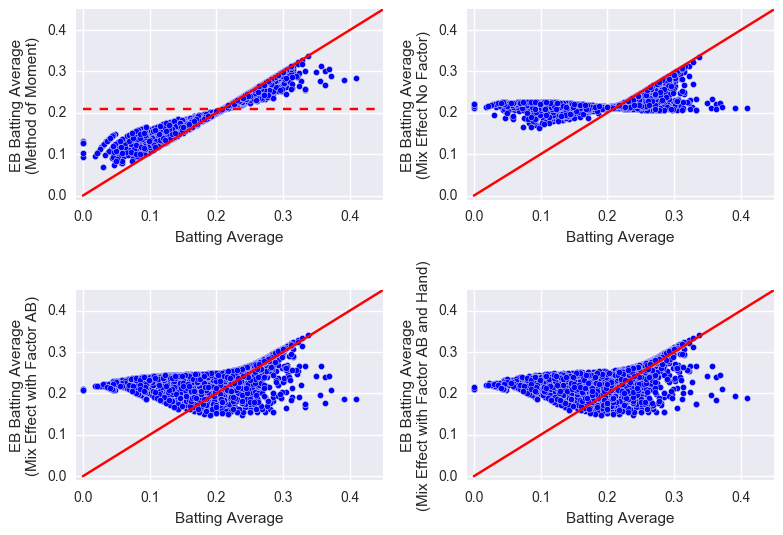

In [43]:
#Summary
fig = plt.figure()
x = np.arange(0.0,0.5,0.01)

ax1 = plt.subplot(221) 
ax1.scatter(career.Average_rate, ar0_post)
ax1.plot(x,x,'r')
ax1.plot(x,np.array([alpha0 / (alpha0 + beta0)] * len(x)),'r--')
ax1.set_xlabel('Batting Average')
ax1.set_ylabel('EB Batting Average\n(Method of Moment)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

ax2 = plt.subplot(222) 
ax2.scatter(career.Average_rate, ar_0_post)
ax2.plot(x,x,'r')
ax2.set_xlabel('Batting Average')
ax2.set_ylabel('EB Batting Average\n(Mix Effect No Factor)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

ax3 = plt.subplot(223) 
ax3.scatter(career.Average_rate, ar_1_post)
ax3.plot(x,x,'r')
ax3.set_xlabel('Batting Average')
ax3.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

ax4 = plt.subplot(224) 
ax4.scatter(career.Average_rate, ar_2_post)
ax4.plot(x,x,'r')
ax4.set_xlabel('Batting Average')
ax4.set_ylabel('EB Batting Average\n(Mix Effect with Factor AB and Hand)')
plt.xlim([-0.01,0.45])
plt.ylim([-0.01,0.45])

plt.tight_layout(h_pad=1.1)
plt.show()

II. Hypothesis Testing

III. Validation

IV. Conclusion